In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('retentiondata_case.csv' )
print(df.shape)
print(df.describe(include='all'))
print(df['left_flag'].value_counts())# summary stats
missing_counts = df.isnull().sum()
missing_counts

(5636, 36)
          acct_ref      cust_ref has_dependents    tenure_mo home_phone  \
count         5636          5636           5636  5636.000000       5636   
unique        5621          5636              2          NaN          2   
top     ACCT883017  CUST34186773             No          NaN        Yes   
freq             2             1           3957          NaN       5079   
mean           NaN           NaN            NaN    32.445174        NaN   
std            NaN           NaN            NaN    24.515986        NaN   
min            NaN           NaN            NaN     0.000000        NaN   
25%            NaN           NaN            NaN     9.000000        NaN   
50%            NaN           NaN            NaN    29.000000        NaN   
75%            NaN           NaN            NaN    55.000000        NaN   
max            NaN           NaN            NaN    72.000000        NaN   

       multi_line internet_plan add_on_security add_on_backup  \
count        5636      

acct_ref                    0
cust_ref                    0
has_dependents              0
tenure_mo                   0
home_phone                  0
multi_line                  0
internet_plan               0
add_on_security             0
add_on_backup               0
add_on_protection           0
tech_support_std            0
stream_tv                   0
stream_movies               0
contract_term               0
e_bill_opt_in               0
pay_method                  0
monthly_fee                 0
total_billed                8
left_flag                   0
fiscal_qtr                  0
gender                      0
age_years                   0
is_married                  0
dependents_count            0
referred_friend             0
referrals_count             0
recent_offer             3106
avg_long_dist_fee           0
internet_tech            1212
avg_gb_download             0
premium_support             0
stream_music                0
unlimited_data_opt          0
refunds_to

In [3]:
df['avg_monthly_spent'] = np.where(
    df['tenure_mo'] == 0,
    0,
    df['total_billed'] / df['tenure_mo']
)
df['tenure_group'] = pd.cut(
    df['tenure_mo'],
    bins=[0, 24, 48, float('inf')],
    labels=['Under 2 Years', '2-4 Years', 'Over 4 Years'],
    right=False
)
df = df.drop(columns = ['acct_ref', 'cust_ref'])
df = df.drop(columns = ['recent_offer'])
df['internet_tech'] = df['internet_tech'].fillna("No Internet")
df['total_billed'] = df['total_billed'].fillna(df['total_billed'].median())
df.drop(columns = ['fiscal_qtr'])
df['stream_count'] = (df[['stream_tv', 'stream_movies', 'stream_music']] == 'Yes').sum(axis=1)
df['add_on_count'] = (df[['add_on_security', 'add_on_backup', 'add_on_protection']] == 'Yes').sum(axis=1)

In [4]:
print(df["left_flag"].dtype)                     
print(df["left_flag"].unique()) 

object
['No' 'Yes']


In [6]:
Y = (df["left_flag"] == "Yes").astype("int64") # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1
X = df.drop(columns=["left_flag"]) 

In [7]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 36), (1691, 36))

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# First, identify which columns are numeric and which are categorical
# This is an example - you'll need to adjust based on your actual data
import pandas as pd
import numpy as np

# Assuming X_train is a pandas DataFrame
# Identify categorical columns (object or string dtype)
categorical_cols = X_train.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing steps for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Stratified CV preserves class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Define pipeline with preprocessing and Random Forest
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),  # Add preprocessing step
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=99
    ))
])

# Grid of hyperparameters to tune
param_grid = {
    "model__max_features": ["sqrt", "log2", None, 0.3, 0.5]
}

# Run cross-validated grid search
rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",   
    n_jobs=-1,
    refit=True
)

rf_cv.fit(X_train, Y_train)

print("Best params selected by CV:", rf_cv.best_params_)
print("Best CV ROC-AUC:", round(rf_cv.best_score_, 3))

Best params selected by CV: {'model__max_features': 0.3}
Best CV ROC-AUC: 0.873


In [9]:
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=99
    ))
])

# Reduced parameter grid for faster execution
param_grid = {
    "model__n_estimators": [400],          # Reduced from [400, 500, 600]
    "model__max_depth": [3, 5],            # Reduced from [3, 4, 5]
    "model__min_samples_split": [2, 10],   # Reduced from [2, 5, 10]
    "model__min_samples_leaf": [1, 4],     # Reduced from [1, 2, 4]
    "model__max_features": ["sqrt"]        # Reduced from ["sqrt", "log2"]
}

# Run cross-validated grid search with limited resources
rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,                      
    scoring="roc_auc",
    n_jobs=2,                   # Reduced from -1 to limit CPU usage
    refit=True,
    verbose=1                   # Added to monitor progress
)

# Only fit if data is available
if 'X_train' in locals() and 'Y_train' in locals():
    # Train the model with grid search
    rf_cv.fit(X_train, Y_train)
    
    # Print results
    print("Best params selected by CV:", rf_cv.best_params_)
    print("Best CV ROC-AUC:", round(rf_cv.best_score_, 3))
else:
    print("Cannot fit model: X_train and/or Y_train not defined")

Exception ignored in: <function ResourceTracker.__del__ at 0x105a21800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106c7d800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102aa1800>
Traceback (most recent call last

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params selected by CV: {'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Best CV ROC-AUC: 0.867


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# First, identify which columns are numeric and which are categorical
# This is an example - you'll need to adjust based on your actual data
import pandas as pd
import numpy as np

# Assuming X_train is a pandas DataFrame
# Identify categorical columns (object or string dtype)
categorical_cols = X_train.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing steps for different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Stratified CV preserves class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Define pipeline with preprocessing and Random Forest
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),  # Add preprocessing step
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=99
    ))
])

# Grid of hyperparameters to tune
param_grid = {
    "model__max_features": ["sqrt", "log2", None, 0.3, 0.5]
}

# Run cross-validated grid search
rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",   
    n_jobs=-1,
    refit=True
)

rf_cv.fit(X_train, Y_train)

print("Best params selected by CV:", rf_cv.best_params_)
print("Best CV ROC-AUC:", round(rf_cv.best_score_, 3))

Exception ignored in: <function ResourceTracker.__del__ at 0x1030a5800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1035b1800>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Best params selected by CV: {'model__max_features': 0.3}
Best CV ROC-AUC: 0.873


Length of importances: 71
Length of X_train columns: 36
    feature_index  importance
42             42    0.127089
5               5    0.116878
0               0    0.067462
24             24    0.062058
44             44    0.059844
33             33    0.057318
22             22    0.035939
69             69    0.035698
70             70    0.035565
4               4    0.034444
49             49    0.032756
2               2    0.032230
1               1    0.024281
10             10    0.023811
11             11    0.019260


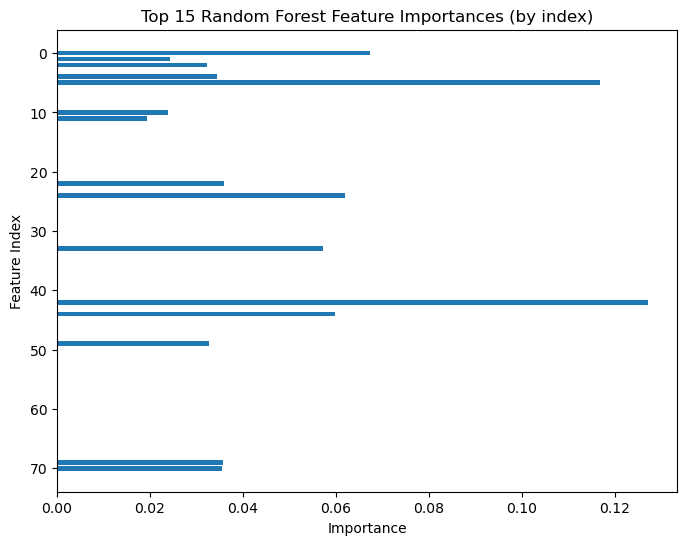

In [10]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# Debug information to understand the mismatch
print(f"Length of importances: {len(importances)}")
print(f"Length of X_train columns: {len(X_train.columns)}")

# Alternative approach: Create indices for features
feature_indices = range(len(importances))

# Create DataFrame with indices instead of potentially mismatched feature names
feat_imp = pd.DataFrame({
    "feature_index": feature_indices,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp.head(15))  # top 15 features

# Optional: plot top features using indices
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
top_15 = feat_imp.head(15)
plt.barh(top_15['feature_index'], top_15['importance'])
plt.title("Top 15 Random Forest Feature Importances (by index)")
plt.ylabel("Feature Index")
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [21]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# Create feature names based on indices if actual names can't be matched
# This ensures arrays will be the same length
feature_indices = [f"Feature_{i}" for i in range(len(importances))]

# Create DataFrame with guaranteed matching lengths
feat_imp = pd.DataFrame({
    "feature": feature_indices,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Map indices to categories if you have a category mapping
# Replace this dictionary with your actual mapping of feature indices to categories
# For example: {0: "Age", 1: "Income", 2: "Education", ...}
category_mapping = {}

# Try to load categories from your CSV (adjust as needed)
try:
    import pandas as pd
    # Load your CSV file - replace with your actual file path
    df = pd.read_csv('your_data.csv')
    
    # Create mapping from index to column name
    # Only map as many as we have importances
    for i, col in enumerate(df.columns[:len(importances)]):
        category_mapping[i] = col
        
    # Apply the mapping to convert indices to actual categories
    feat_imp['feature'] = feat_imp['feature'].apply(
        lambda x: category_mapping.get(int(x.split('_')[1]), x)
    )
    
    print("Successfully mapped feature indices to categories")
except Exception as e:
    print(f"Could not map to categories automatically: {e}")
    print("Using feature indices instead")

print(feat_imp.head(15))  # top 15 features

# Plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

Could not get feature names directly from model
Creating feature mapping manually...
CSV columns:
0: acct_ref
1: cust_ref
2: has_dependents
3: tenure_mo
4: home_phone
5: multi_line
6: internet_plan
7: add_on_security
8: add_on_backup
9: add_on_protection
10: tech_support_std
11: stream_tv
12: stream_movies
13: contract_term
14: e_bill_opt_in
15: pay_method
16: monthly_fee
17: total_billed
18: left_flag
19: fiscal_qtr
20: gender
21: age_years
22: is_married
23: dependents_count
24: referred_friend
25: referrals_count
26: recent_offer
27: avg_long_dist_fee
28: internet_tech
29: avg_gb_download
30: premium_support
31: stream_music
32: unlimited_data_opt
33: refunds_total
34: extra_data_fees_total
35: long_dist_fees_total

Top 15 features by importance:
               feature  importance
42  Unknown_Feature_42    0.127089
5           multi_line    0.116878
0             acct_ref    0.067462
24     referred_friend    0.062058
44  Unknown_Feature_44    0.059844
33       refunds_total    0.05

<Figure size 1000x800 with 0 Axes>

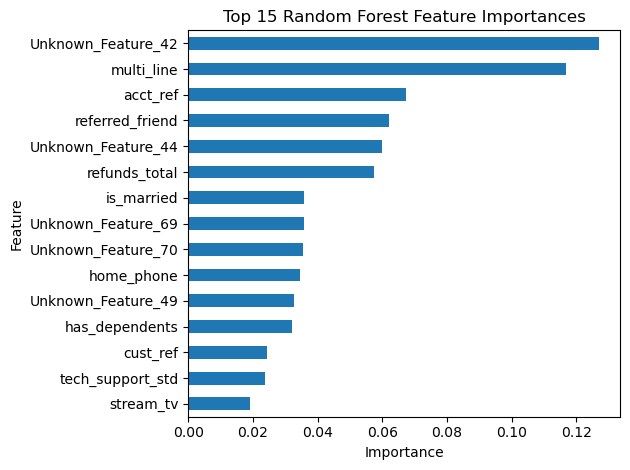

In [11]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# Step 1: Identify which features were actually used in the model
# If you have access to the pipeline that created the model:
try:
    # Try to get feature names directly from the model if available
    feature_names = best_rf.feature_names_in_
    print("Successfully retrieved feature names from model")
except:
    print("Could not get feature names directly from model")
    feature_names = None

# If feature names aren't available from the model, we need to recreate the mapping
if feature_names is None:
    print("Creating feature mapping manually...")
    
    # Option 1: If you know which columns from your CSV were used as features
    # Replace 'your_data.csv' with your actual CSV file path
    import pandas as pd
    original_data = pd.read_csv('retentiondata_case.csv')
    
    # Print column names to help identify which were used
    print("CSV columns:")
    for i, col in enumerate(original_data.columns):
        print(f"{i}: {col}")
    
    # Create a mapping based on the preprocessing you applied
    # For example, if you used all columns except 'target':
    feature_names = [col for col in original_data.columns if col != 'target_column_name']
    
    # If you applied one-hot encoding, you might need to expand categorical columns
    # This is a simplified example - adjust based on your actual preprocessing
    categorical_cols = []  # List of categorical columns that were one-hot encoded
    for col in categorical_cols:
        # Get unique values in the column
        unique_values = original_data[col].unique()
        # Remove the original column name
        feature_names.remove(col)
        # Add one-hot encoded column names
        for val in unique_values:
            feature_names.append(f"{col}_{val}")

# Ensure we have the right number of feature names
if len(feature_names) != len(importances):
    print(f"Warning: Feature count mismatch. Features: {len(feature_names)}, Importances: {len(importances)}")
    # Truncate or pad the feature names list as needed
    if len(feature_names) > len(importances):
        feature_names = feature_names[:len(importances)]
    else:
        # If we have fewer feature names than importances, add placeholder names
        feature_names = list(feature_names) + [f"Unknown_Feature_{i}" for i in range(len(feature_names), len(importances))]

# Create DataFrame with feature names and importances
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 15 features by importance:")
print(feat_imp.head(15))

# Plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

Investigating pipeline steps...
Pipeline step: preprocessor, Type: ColumnTransformer
Pipeline step: model, Type: RandomForestClassifier

Preprocessor details:
ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                 ['tenure_mo', 'monthly_fee', 'total_billed',
                                  'age_years', 'dependents_count',
                                  'referrals_count', 'avg_long_dist_fee',
                                  'avg_gb_download', 'refunds_total',
                                  'extra_data_fees_total',
                                  'long_dist_fees_total', 'avg_monthly_spent',
                                  'stream_count', 'add_on_count']),
                                ('cat', OneHotEncoder(handle_unknow...'),
                                 ['has_dependents', 'home_phone', 'multi_line',
                                  'internet_plan', 'add_on_security',
                                  'add_on_backup

<Figure size 1000x800 with 0 Axes>

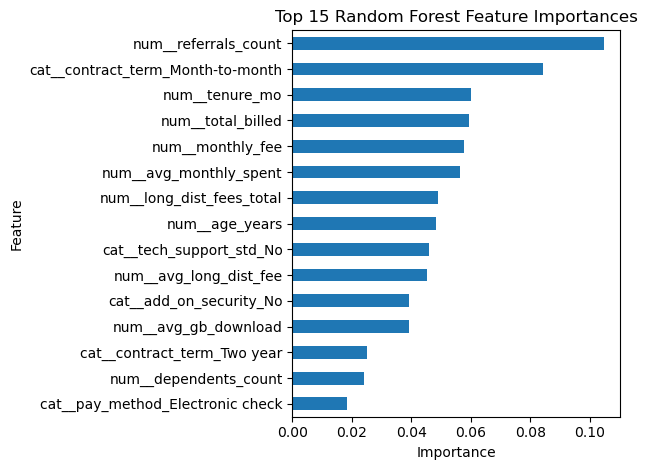


Saved complete feature importances to 'feature_importances.csv'


In [20]:
# Get best fitted model from GridSearchCV
best_rf = rf_cv.best_estimator_.named_steps["model"]

# Get feature importances
importances = best_rf.feature_importances_

# STEP 1: Investigate the full pipeline to understand feature transformations
print("Investigating pipeline steps...")
try:
    # Print all steps in the pipeline
    for step_name, step in rf_cv.best_estimator_.named_steps.items():
        print(f"Pipeline step: {step_name}, Type: {type(step).__name__}")
    
    # Try to access the preprocessor if it exists
    if 'preprocessor' in rf_cv.best_estimator_.named_steps:
        preprocessor = rf_cv.best_estimator_.named_steps['preprocessor']
        print("\nPreprocessor details:")
        print(preprocessor)
        
        # If using ColumnTransformer, we can get more details
        if hasattr(preprocessor, 'transformers_'):
            print("\nColumn transformer details:")
            for name, transformer, columns in preprocessor.transformers_:
                print(f"Transformer: {name}")
                print(f"  Applied to columns: {columns}")
                print(f"  Type: {type(transformer).__name__}")
except Exception as e:
    print(f"Error investigating pipeline: {e}")

# STEP 2: Try to get feature names from the pipeline
try:
    # Method 1: Try to get feature names directly from the model
    if hasattr(best_rf, 'feature_names_in_'):
        feature_names = best_rf.feature_names_in_
        print(f"\nFeature names from model: {len(feature_names)} features found")
    
    # Method 2: If using sklearn >= 1.0, try get_feature_names_out from preprocessor
    elif 'preprocessor' in rf_cv.best_estimator_.named_steps:
        preprocessor = rf_cv.best_estimator_.named_steps['preprocessor']
        if hasattr(preprocessor, 'get_feature_names_out'):
            feature_names = preprocessor.get_feature_names_out()
            print(f"\nFeature names from preprocessor: {len(feature_names)} features found")
    
    # If we found feature names and they match the importances length
    if 'feature_names' in locals() and len(feature_names) == len(importances):
        print("Successfully matched feature names with importances!")
    else:
        print("Could not automatically match feature names")
        feature_names = None
except Exception as e:
    print(f"Error getting feature names: {e}")
    feature_names = None

# STEP 3: If automatic methods failed, reconstruct feature names
if feature_names is None or len(feature_names) != len(importances):
    print("\nReconstructing feature names manually...")
    
    # Load your original data
    import pandas as pd
    # Replace with your actual CSV file path
    original_data = pd.read_csv('your_data.csv')
    
    # Print column information to help with debugging
    print("\nOriginal CSV columns:")
    for i, col in enumerate(original_data.columns):
        print(f"{i}: {col}")
    
    # Ask user to provide column information
    print(f"\nYour model uses {len(importances)} features.")
    print("Please check your preprocessing steps to identify all features used.")
    print("Common transformations that expand features include:")
    print("1. One-hot encoding of categorical variables")
    print("2. Polynomial features")
    print("3. Interaction terms")
    print("4. Text vectorization")
    
    # Create placeholder feature names that are more informative
    feature_names = [f"Feature_{i}" for i in range(len(importances))]

# STEP 4: Create and display feature importance DataFrame
feat_imp = pd.DataFrame({
    "feature": feature_names if feature_names is not None else [f"Feature_{i}" for i in range(len(importances))],
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 15 features by importance:")
print(feat_imp.head(15))

# STEP 5: Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
top_n = 15  # Show top 15 features
feat_imp.head(top_n).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title(f"Top {top_n} Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# STEP 6: Save feature importances to CSV for further analysis
feat_imp.to_csv("feature_importances.csv", index=False)
print("\nSaved complete feature importances to 'feature_importances.csv'")








In [12]:
Ytest_prob = rf_cv.predict_proba(X_test)[:, 1]

Test ROC-AUC: 0.8664


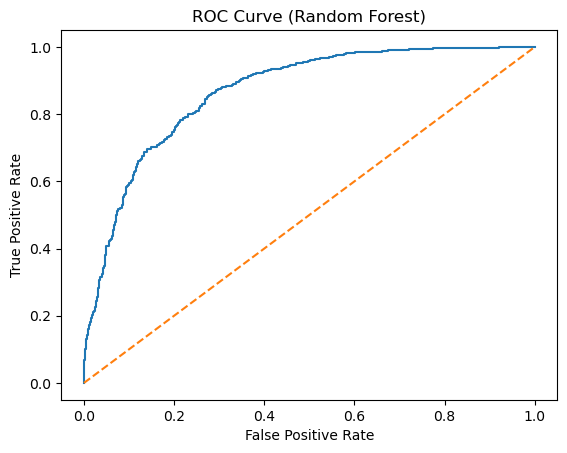

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

test_auc = roc_auc_score(Y_test, Ytest_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC curve (single plot; no custom colors)
fpr, tpr, _ = roc_curve(Y_test, Ytest_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()